In [1]:
import numpy as np
import torch
from collections import OrderedDict
import matplotlib.pyplot as plt
from matplotlib.lines import lineStyles
import time

# Check if cuda is available
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

# 设置随机种子函数
def setup_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cuda.matmul.allow_tf32 = False
        torch.backends.cudnn.allow_tf32 = False

cuda


In [3]:
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        self.depth = len(layers) - 1
        self.activation = torch.nn.Softplus
        layer_list = list()
        for i in range(self.depth - 1):
            layer = torch.nn.Linear(layers[i], layers[i + 1])
            # He 初始化
            torch.nn.init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='relu')
            layer_list.append(('layer_%d' % i, layer))
            layer_list.append(('bn_%d' % i, torch.nn.BatchNorm1d(layers[i + 1])))
            layer_list.append(('activation_%d' % i, self.activation()))
        last_layer = torch.nn.Linear(layers[-2], layers[-1])
        torch.nn.init.xavier_normal_(last_layer.weight)
        layer_list.append(('layer_%d' % (self.depth - 1), last_layer))
        layerDict = OrderedDict(layer_list)
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        # 假设输出的最后一个维度是 4，将其拆分为 4 个张量
        out = self.layers(x)
        # return out   ->return one dimentional vector
        N1, N2, N3, N4 = torch.split(out, 1, dim=1)
        return N1, N2, N3, N4

In [ ]:
def nan_hook(module, grad_input, grad_output):
    # 检查输入梯度中是否存在 NaN
    if any(torch.isnan(g).any() for g in grad_input if g is not None):
        print(f"NaN梯度出现在模块: {module.__class__.__name__}")
        # 可选：记录梯度值或触发中断
        # raise ValueError("检测到NaN梯度，训练终止")

# 初值训练PINN网络

In [4]:
class Multi_hPINN():
    def __init__(self, X_train1,layers):
        # super(Multi_hPINN, self).__init__()
        # data
        self.x_t0 = torch.tensor(X_train1[:, 0:1], requires_grad=True).float().to(device)
        self.y_t0 = torch.tensor(X_train1[:, 1:2], requires_grad=True).float().to(device)
        self.t0 = torch.tensor(X_train1[:, 2:3], requires_grad=True).float().to(device)
        # parameters
        self.alpha = torch.tensor((5/180)*torch.pi).float().to(device)
        self.U_inf = torch.tensor(1508.55).float().to(device)
        self.T_inf = torch.tensor(226.51).float().to(device)
        self.rho_inf = torch.tensor(1.841e-2).float().to(device)
        self.P_inf = torch.tensor(1.197e3).float().to(device)
        self.C_inf = torch.tensor(301.71).float().to(device)
        self.S = torch.tensor(5.5811e-4).float().to(device)
        self.R = torch.tensor(287).float().to(device)
        self.mu0 = torch.tensor(1.789e-5).float().to(device)
        self.C = torch.tensor(110.4).float().to(device)
        self.T0 = torch.tensor(288.15).float().to(device)
        self.Tve = torch.tensor(3030).float().to(device)
        self.Pr = torch.tensor(0.72).float().to(device)
        self.L = torch.tensor(1.675e-4).float().to(device)
        self.loss = None
        self.layers = layers

        # 添加可训练的p参数
        self.p = torch.nn.Parameter(torch.tensor(2.0).float().to(device))
        self.p_log = []

        # deep neural networks
        self.dnn = DNN(layers).to(device)

        # optimizers: using the same settings - 使用更合理的学习率
        self.optimizer_adam = torch.optim.Adam([
            {'params': self.dnn.parameters()},
            # {'params': [self.p], 'lr': 0.001}  # 降低p参数的学习率
        ], lr=10)

        self.optimizer_lbfgs = torch.optim.LBFGS(
            list(self.dnn.parameters()),# + [self.p],
            lr=0.1,
            max_iter=1000,  # 最大迭代次数
            max_eval=1000,  # 最大评估次数
            history_size=50,
            tolerance_grad=1e-5,
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"
        )
        self.iter = 0

    def control_fun(self, x, y):
        """控制函数 4xy(1-y)^p，用于平滑地连接解析解和神经网络输出"""
        return 4 * x * y * (torch.ones_like(y) - y) ** self.p

    def net_u(self,x,y,t):
        N1,_,_,_ = self.dnn(torch.cat([x, y, t], dim=1))

        # 控制函数权重
        weight = self.control_fun(x, y)

        # 解析形式部分
        u_analytic = (self.S*y*self.U_inf*torch.cos(self.alpha))/(self.S*y+self.S*self.L*x*(torch.ones_like(y)-y)+1.0e-6)

        # 神经网络部分
        u_nn = self.L*self.S**2*x*y*(torch.ones_like(y)-y)*N1

        # 组合输出
        u = (1 - weight) * u_analytic + weight * u_nn
        u_x = torch.autograd.grad(
            u, x,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_y = torch.autograd.grad(
            u, y,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_t = torch.autograd.grad(
            u, t,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        # print(f'u:{torch.mean(u)},{torch.mean(u_x)},{torch.mean(u_y)},{torch.mean(u_t)}')
        return u,u_x,u_y,u_t

    def net_v(self,x,y,t):
        _,N2,_,_ = self.dnn(torch.cat([x, y, t], dim=1))

        # 控制函数权重
        weight = self.control_fun(x, y)

        # 解析形式部分
        v_analytic = (-self.S*y*self.U_inf*torch.sin(self.alpha))/(self.S*y+self.S*self.L*x*(torch.ones_like(y)-y)+1.0e-6)

        # 神经网络部分
        v_nn = self.L*self.S**2*x*y*(torch.ones_like(y)-y)*N2

        # 组合输出
        v = (1 - weight) * v_analytic + weight * v_nn

        v_x = torch.autograd.grad(
            v, x,
            grad_outputs=torch.ones_like(v),
            retain_graph=True,
            create_graph=True
        )[0]
        v_y = torch.autograd.grad(
            v, y,
            grad_outputs=torch.ones_like(v),
            retain_graph=True,
            create_graph=True
        )[0]
        v_t = torch.autograd.grad(
            v, t,
            grad_outputs=torch.ones_like(v),
            retain_graph=True,
            create_graph=True
        )[0]
        # print(f'v:{torch.mean(v)},{torch.mean(v_x)},{torch.mean(v_y)},{torch.mean(v_t)}')
        return v,v_x,v_y,v_t

    def net_T(self,x,y,t):
        _,_,N3,_ = self.dnn(torch.cat([x, y, t], dim=1))

        # 控制函数权重，使用x(1-y)
        weight = (x*(torch.ones_like(y)-y))**self.p

        # 解析形式部分
        T_analytic = self.T_inf

        # 计算神经网络部分所需的边界梯度
        y0 = torch.zeros_like(y,requires_grad=True)
        _,_,N30,_ = self.dnn(torch.cat([x, y0, t], dim=1))
        N3_y0 = torch.autograd.grad(
            N30,
            y0,
            grad_outputs=torch.ones_like(N30),
            retain_graph=True,
            create_graph=True
        )[0]

        # 神经网络部分
        T_nn = self.S*self.L*(N3-N30+1/self.p*N3_y0+self.T_inf/(self.L*self.S))

        # 组合输出
        T = (1 - weight) * T_analytic + weight * T_nn

        T_x = torch.autograd.grad(
            T,x,
            grad_outputs=torch.ones_like(T),
            retain_graph=True,
            create_graph=True
        )[0]
        T_y = torch.autograd.grad(
            T,y,
            grad_outputs=torch.ones_like(T),
            retain_graph=True,
            create_graph=True
        )[0]
        T_t = torch.autograd.grad(
            T,t,
            grad_outputs=torch.ones_like(T),
            retain_graph=True,
            create_graph=True
        )[0]
        # print(f'T:{torch.mean(T)},{torch.mean(T_x)},{torch.mean(T_y)},{torch.mean(T_t)}')
        return T,T_x,T_y,T_t

    def net_rho(self,x,y,t):
        _,_,_,N4 = self.dnn(torch.cat([x, y, t], dim=1))

        # 控制函数权重，使用x(1-y)
        weight = (x*(torch.ones_like(y)-y))**self.p

        # 解析形式部分
        rho_analytic = self.rho_inf

        # 神经网络部分
        rho_nn = self.S*self.L*N4

        # 组合输出
        rho = (1 - weight) * rho_analytic + weight * rho_nn

        rho_x = torch.autograd.grad(
            rho,x,
            grad_outputs=torch.ones_like(rho),
            retain_graph=True,
            create_graph=True
        )[0]
        rho_y = torch.autograd.grad(
            rho,y,
            grad_outputs=torch.ones_like(rho),
            retain_graph=True,
            create_graph=True
        )[0]
        rho_t = torch.autograd.grad(
            rho,t,
            grad_outputs=torch.ones_like(rho),
            retain_graph=True,
            create_graph=True
        )[0]
        # print(f'rho:{torch.mean(rho)},{torch.mean(rho_x)},{torch.mean(rho_y)},{torch.mean(rho_t)}')
        return rho,rho_x,rho_y,rho_t

    def calculate_cp_T(self, T):
        # 保证温度有一个最小值，防止除以接近零的数
        T_safe = torch.clamp(T, min=1.0)

        # 当T<600时，使用常数值
        cp_low = 1004.5

        # 当T>=600时的计算逻辑
        # 计算比值并限制其上限，防止exp爆炸
        ratio = torch.clamp(self.Tve / T_safe, max=20.0)

        # 更稳定的计算方式：避免大指数和分母为零的情况
        # 当ratio很大时，exp(ratio)>>1，所以exp(ratio)/(exp(ratio)-1)约等于1
        # 当ratio较小时，使用完整表达式
        # 使用log-sum-exp技巧提高数值稳定性
        exp_ratio = torch.exp(ratio)
        # 安全的分母计算
        denominator = exp_ratio - 1.0
        # 添加epsilon防止分母为零
        denominator = torch.clamp(denominator, min=1e-10)

        # 计算完整表达式
        term = (ratio**2) * (exp_ratio / denominator**2)

        # 组合最终结果
        cp_high = (7.0 / 2.0) * self.R + self.R * term

        # 使用torch.where选择
        return torch.where(T < 600, cp_low, cp_high)

    # function
    def function(self,x,y,t):
        # 速度u,v 温度T 密度rho, 压强p,
        u, u_x, u_y, u_t = self.net_u(x, y, t)
        v, v_x, v_y, v_t = self.net_v(x, y, t)
        T, T_x, T_y, T_t = self.net_T(x, y, t)
        rho, rho_x, rho_y, rho_t = self.net_rho(x, y, t)

        # 安全裁剪，防止极端值
        u_safe = torch.clamp(u, min=-2000.0, max=2000.0)
        v_safe = torch.clamp(v, min=-2000.0, max=2000.0)
        T_safe = torch.clamp(T, min=1.0, max=5000.0)
        rho_safe = torch.clamp(rho, min=1e-6, max=10.0)

        # 对导数也进行适当裁剪，避免极值
        max_deriv = 1e6
        u_x = torch.clamp(u_x, min=-max_deriv, max=max_deriv)
        u_y = torch.clamp(u_y, min=-max_deriv, max=max_deriv)
        u_t = torch.clamp(u_t, min=-max_deriv, max=max_deriv)
        v_x = torch.clamp(v_x, min=-max_deriv, max=max_deriv)
        v_y = torch.clamp(v_y, min=-max_deriv, max=max_deriv)
        v_t = torch.clamp(v_t, min=-max_deriv, max=max_deriv)
        T_x = torch.clamp(T_x, min=-max_deriv, max=max_deriv)
        T_y = torch.clamp(T_y, min=-max_deriv, max=max_deriv)
        T_t = torch.clamp(T_t, min=-max_deriv, max=max_deriv)
        rho_x = torch.clamp(rho_x, min=-max_deriv, max=max_deriv)
        rho_y = torch.clamp(rho_y, min=-max_deriv, max=max_deriv)
        rho_t = torch.clamp(rho_t, min=-max_deriv, max=max_deriv)

        # 计算压力
        p = rho_safe * self.R * T_safe
        p_x = torch.autograd.grad(
            p, x,
            grad_outputs=torch.ones_like(p),
            retain_graph=True,
            create_graph=True
        )[0]
        p_y = torch.autograd.grad(
            p, y,
            grad_outputs=torch.ones_like(p),
            retain_graph=True,
            create_graph=True
        )[0]
        p_x = torch.clamp(p_x, min=-max_deriv, max=max_deriv)
        p_y = torch.clamp(p_y, min=-max_deriv, max=max_deriv)

        mu_T = self.mu0 * ((self.T0 + self.C) / (T_safe + self.C)) * (T_safe / self.T0) ** 1.5
        cp_T = self.calculate_cp_T(T_safe)
        k_T = mu_T * cp_T / self.Pr

        # 分步计算粘性项，应用裁剪
        part1 = (4/3) * mu_T * u_x - (2/3) * mu_T * v_y
        part1_x = torch.autograd.grad(
            part1, x,
            grad_outputs=torch.ones_like(part1),
            retain_graph=True,
            create_graph=True
        )[0]
        part1_x = torch.clamp(part1_x, min=-max_deriv, max=max_deriv)

        part2 = mu_T * (u_y + v_x)
        part2_x = torch.autograd.grad(
            part2, x,
            grad_outputs=torch.ones_like(part2),
            retain_graph=True,
            create_graph=True
        )[0]
        part2_y = torch.autograd.grad(
            part2, y,
            grad_outputs=torch.ones_like(part2),
            retain_graph=True,
            create_graph=True
        )[0]
        part2_x = torch.clamp(part2_x, min=-max_deriv, max=max_deriv)
        part2_y = torch.clamp(part2_y, min=-max_deriv, max=max_deriv)

        part3 = (4/3) * mu_T * v_y - (2/3) * mu_T * u_x
        part3_y = torch.autograd.grad(
            part3, y,
            grad_outputs=torch.ones_like(part3),
            retain_graph=True,
            create_graph=True
        )[0]
        part3_y = torch.clamp(part3_y, min=-max_deriv, max=max_deriv)

        part4 = k_T * T_x
        part4_x = torch.autograd.grad(
            part4, x,
            grad_outputs=torch.ones_like(part4),
            retain_graph=True,
            create_graph=True
        )[0]
        part4_x = torch.clamp(part4_x, min=-max_deriv, max=max_deriv)

        part5 = k_T * T_y
        part5_y = torch.autograd.grad(
            part5, y,
            grad_outputs=torch.ones_like(part5),
            retain_graph=True,
            create_graph=True
        )[0]
        part5_y = torch.clamp(part5_y, min=-max_deriv, max=max_deriv)

        # 计算方程残差并应用裁剪
        f1 = rho_t + u_safe * rho_x + rho_safe * u_x + v_safe * rho_y + v_x * rho_safe
        f2 = rho_safe * (u_t + u_safe * u_x + v_safe * u_y) + p_x - part1_x - part2_y
        f3 = rho_safe * (v_t + u_safe * v_x + v_safe * v_y) + p_y - part3_y - part2_x

        # 能量方程各项分别计算并裁剪
        term1 = torch.clamp(rho_safe * cp_T * T_t, min=-max_deriv, max=max_deriv)
        term2 = torch.clamp(rho_safe * cp_T * u_safe * T_x, min=-max_deriv, max=max_deriv)
        term3 = torch.clamp(rho_safe * cp_T * v_safe * T_y, min=-max_deriv, max=max_deriv)
        term4 = torch.clamp(p * (u_x + v_y), min=-max_deriv, max=max_deriv)
        term5 = torch.clamp(-part4_x, min=-max_deriv, max=max_deriv)
        term6 = torch.clamp(-part5_y, min=-max_deriv, max=max_deriv)
        term7 = torch.clamp(-(4/3) * mu_T * (u_x**2), min=-max_deriv, max=max_deriv)
        term8 = torch.clamp(-mu_T * (u_y**2), min=-max_deriv, max=max_deriv)
        term9 = torch.clamp(-mu_T * (v_x**2), min=-max_deriv, max=max_deriv)
        term10 = torch.clamp(-(4/3) * mu_T * (v_y**2), min=-max_deriv, max=max_deriv)
        term11 = torch.clamp((4/3) * mu_T * u_x * v_y, min=-max_deriv, max=max_deriv)
        term12 = torch.clamp(-2 * mu_T * u_y * v_x, min=-max_deriv, max=max_deriv)

        # 计算能量方程的残差
        f4 = term1 + term2 + term3 + term4 + term5 + term6 + term7 + term8 + term9 + term10 + term11 + term12

        # 对所有残差进行最终裁剪
        max_residual = 1e8
        f1 = torch.clamp(f1, min=-max_residual, max=max_residual)
        f2 = torch.clamp(f2, min=-max_residual, max=max_residual)
        f3 = torch.clamp(f3, min=-max_residual, max=max_residual)
        f4 = torch.clamp(f4, min=-max_residual, max=max_residual)
        # print(f'f1:{torch.mean(f1**2)},f2:{torch.mean(f2**2)},f3:{torch.mean(f3**2)},f4:{torch.mean(f4**2)}')

        return f1, f2, f3, f4


    # 在function方法之后添加一个加权损失计算方法
    def weighted_loss(self, x, y, t):
        f1, f2, f3, f4 = self.function(x, y, t)

        # 计算当前批次中每个损失的平均大小
        f1_mean = torch.mean(torch.abs(f1))
        f2_mean = torch.mean(torch.abs(f2))
        f3_mean = torch.mean(torch.abs(f3))
        f4_mean = torch.mean(torch.abs(f4))

        # 计算动态权重（使用均值的倒数）
        eps = 1e-10  # 防止除零
        w1 = 1.0 / (f1_mean + eps)
        w2 = 1.0 / (f2_mean + eps)
        w3 = 1.0 / (f3_mean + eps)
        w4 = 1.0 / (f4_mean + eps)

        # 归一化权重
        total = w1 + w2 + w3 + w4
        w1, w2, w3, w4 = w1/total, w2/total, w3/total, w4/total

        # 应用权重计算加权损失
        loss_f1 = w1 * torch.mean(f1**2)
        loss_f2 = w2 * torch.mean(f2**2)
        loss_f3 = w3 * torch.mean(f3**2)
        loss_f4 = w4 * torch.mean(f4**2)

        return loss_f1, loss_f2, loss_f3, loss_f4

    def closure(self):
        """闭包函数，用于优化过程"""
        self.optimizer.zero_grad()

        # 使用加权损失
        loss_f1, loss_f2, loss_f3, loss_f4 = self.weighted_loss(self.x_t0, self.y_t0, self.t0)


        # 总损失为方程残差
        loss = loss_f1 + loss_f2 + loss_f3 + loss_f4
        self.loss = loss

        # 执行反向传播
        loss.backward()

        # 在更新参数前对梯度进行裁剪
        # 对每个参数组分别应用梯度裁剪
        # torch.nn.utils.clip_grad_norm_(self.dnn.parameters(), max_norm=0.1)


        self.iter += 1
        self.p_log.append(self.p.item())

        if self.iter % 100 == 0:
            print(
                f'Iter {self.iter}, p:{self.p.item():.2f}, Loss: {loss.item():.5e}, Loss_f1: {loss_f1.item():.5e}, Loss_f2: {loss_f2.item():.5e}, Loss_f3: {loss_f3.item():.5e}, Loss_f4: {loss_f4.item():.5e}'
            )
            # 打印各层梯度范数
            total_norm = 0
            for p in self.dnn.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** 0.5
            print(f"Gradient Norm: {total_norm:.4e}")

        return loss

    def train(self, n_iter, optimizer_type='adam'):
        '''训练模型 其中可以更改优化器的类型，以及训练迭代的设置'''
        # 其中参数n_iter指的是迭代次数 optimizer_type指的是优化器的类型
        self.dnn.train()
        if optimizer_type == 'adam':
            self.optimizer = self.optimizer_adam
            print('\n\t====开始Adam优化====')
        else:
            self.optimizer = self.optimizer_lbfgs
            print('\n\t====开始LBFGS优化====')

        # n_iter指的是迭代次数
        for _ in range(n_iter):
            # print(self.loss_function)
            self.optimizer.step(self.closure)
            if (self.loss < 1e-6):
                break
        # 梯度裁剪
        # torch.nn.utils.clip_grad_norm_(self.dnn.parameters(), max_norm=1.0)

        # 在训练结束后绘制p参数变化曲线
        if len(self.p_log) > 0:
            plt.figure(figsize=(8, 4))
            plt.plot(range(len(self.p_log)), self.p_log)
            plt.title('p参数变化')
            plt.xlabel('迭代次数')
            plt.ylabel('p值')
            plt.grid(True)
            plt.show()

    def predict(self,X):
        x = torch.tensor(X[:,0:1], requires_grad=True).float().to(device)
        y = torch.tensor(X[:,1:2], requires_grad=True).float().to(device)
        t = torch.tensor(X[:,2:3], requires_grad=True).float().to(device)
        self.dnn.eval()

        # 预测速度 u
        u, _, _, _ = self.net_u(x, y, t)

        # 预测速度 v
        v, _, _, _ = self.net_v(x, y, t)

        # 预测温度 T
        T, _, _, _ = self.net_T(x, y, t)

        # 预测密度 rho
        rho, _, _, _ = self.net_rho(x, y, t)

        # 分离梯度并转换为NumPy数组
        u = u.detach().cpu().numpy()
        v = v.detach().cpu().numpy()
        T = T.detach().cpu().numpy()
        rho = rho.detach().cpu().numpy()

        return u, v, T, rho

# 参数初始化

In [5]:
# 物理参数初始化函数
def init_physics_params():
    params = {
        'alpha': torch.tensor((5 / 180) * torch.pi).float().to(device),
        'U_inf': torch.tensor(1508.55).float().to(device),
        'T_inf': torch.tensor(226.51).float().to(device),
        'rho_inf': torch.tensor(1.841e-2).float().to(device),
        'P_inf': torch.tensor(1.197e3).float().to(device),
        'C_inf': torch.tensor(301.71).float().to(device),
        'S': torch.tensor(5.5811e-4).float().to(device),
        'R': torch.tensor(287).float().to(device),
        'mu0': torch.tensor(1.789e-5).float().to(device),
        'C': torch.tensor(110.4).float().to(device),
        'T0': torch.tensor(288.15).float().to(device),
        'Tve': torch.tensor(3030).float().to(device),
        'Pr': torch.tensor(0.72).float().to(device),
        'L': torch.tensor(1.675e-4).float().to(device),
    }
    return params

# 生成初值的数据

In [6]:
# 生成初始时刻的数据
def generate_initial_data(params_dict):
    # 提取参数
    L = params_dict['L'].item()
    S = params_dict['S'].item()
    U_inf = params_dict['U_inf'].item()
    alpha = params_dict['alpha'].item()
    T_inf = params_dict['T_inf'].item()
    rho_inf = params_dict['rho_inf'].item()

    # 生成x, y网格
    x = np.linspace(0, L, 100).reshape(-1, 1)
    y = np.linspace(0, S, 100).reshape(-1, 1)
    x_size = len(x)
    y_size = len(y)
    t0 = np.zeros((x_size * y_size, 1))  # 10000*1
    X, Y = np.meshgrid(x, y)

    # 边界点，初始点数据的生成
    x_0 = np.zeros_like(x)
    x_1 = L * np.ones_like(x)
    y_0 = np.zeros_like(y)
    y_1 = S * np.ones_like(y)

    # 速度，温度和密度的边界条件
    u_t0 = U_inf * np.cos(alpha) * np.ones_like(t0)
    v_t0 = -U_inf * np.sin(alpha) * np.ones_like(t0)
    T_t0 = T_inf * np.ones_like(t0)
    rho_t0 = rho_inf * np.ones_like(t0)

    # 生成的数据集
    X_t0 = np.hstack((X.flatten()[:, None], Y.flatten()[:, None], t0))
    ans_t0 = np.hstack((u_t0, v_t0, T_t0, rho_t0))  # 10000*4

    X_train1 = X_t0
    u_train1 = ans_t0


    # 数据归一化
    X_train1_normalized = X_train1.copy()
    X_train1_normalized[:, 0:1] = X_train1[:, 0:1] / L  # 归一化x
    X_train1_normalized[:, 1:2] = X_train1[:, 1:2] / S  # 归一化y


    return X_train1_normalized, u_train1


# 训练初值

训练区间: 初始时刻！

	====开始Adam优化====
Iter 100, p:2.00, Loss: 2.63202e+05, Loss_f1: 2.03086e-01, Loss_f2: 4.90515e+03, Loss_f3: 3.83476e+02, Loss_f4: 2.57913e+05
Gradient Norm: 1.7254e+04
Iter 200, p:2.00, Loss: 4.82804e+05, Loss_f1: 7.88023e-01, Loss_f2: 9.07611e+03, Loss_f3: 7.35579e+02, Loss_f4: 4.72991e+05
Gradient Norm: 2.5973e+04
Iter 300, p:2.00, Loss: 2.41137e+05, Loss_f1: 1.55721e-01, Loss_f2: 4.51688e+03, Loss_f3: 3.81357e+02, Loss_f4: 2.36239e+05
Gradient Norm: 2.4340e+04
Iter 400, p:2.00, Loss: 3.00436e+05, Loss_f1: 2.57101e-01, Loss_f2: 5.62642e+03, Loss_f3: 4.61172e+02, Loss_f4: 2.94348e+05
Gradient Norm: 2.4206e+04
Iter 500, p:2.00, Loss: 3.25248e+05, Loss_f1: 3.65836e-01, Loss_f2: 6.05997e+03, Loss_f3: 5.15218e+02, Loss_f4: 3.18672e+05
Gradient Norm: 2.3471e+04
Iter 600, p:2.00, Loss: 1.97968e+05, Loss_f1: 1.07843e-01, Loss_f2: 3.69965e+03, Loss_f3: 3.12026e+02, Loss_f4: 1.93956e+05
Gradient Norm: 2.3103e+04
Iter 700, p:2.00, Loss: 2.18906e+05, Loss_f1: 1.47777e-01, Loss_f2: 4

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21442 (\N{CJK UNIFIED IDEOGRAPH-53C2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21464 (\N{CJK UNIFIED IDEOGRAPH-53D8}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/

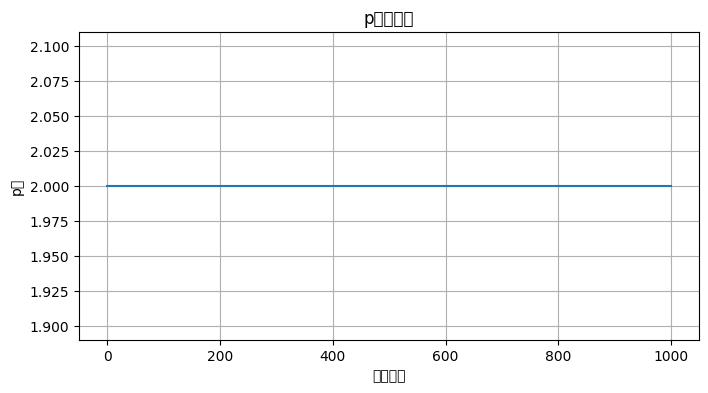


	====开始LBFGS优化====
Iter 1100, p:2.00, Loss: 7.31093e+04, Loss_f1: 1.62743e-02, Loss_f2: 1.36487e+03, Loss_f3: 1.19130e+02, Loss_f4: 7.16253e+04
Gradient Norm: 1.0040e+03


KeyboardInterrupt: 

In [7]:
# 主程序
setup_seed(42)                                 # 设置随机种子

# 训练参数
t_min, t_max = 0.0, 1.0                        # 训练区间
num_block = 2                                  # 区间数
nIter = 1000                                     # 每个区间的迭代次数
params_dict = init_physics_params()            # 数学模型参数
layers = [3, 100, 90, 80, 60, 50, 40, 20, 4]   # 网络层数

# 训练模型
models = []
errors = []
train_times = []
# t_block = np.linspace(t_min, t_max, num_block + 1)
# 第一个区间
print(f'训练区间: 初始时刻！')
X_train1,u_train1 = generate_initial_data(params_dict)
model = Multi_hPINN(X_train1, layers)
start_time = time.time()
model.train(nIter, 'adam')
model.train(nIter,'lbfgs')
u_pred = model.predict(X_train1)
models.append(model)

# 定义绘图函数

In [8]:
def visualize_results(X_vis, results, params_dict):
    u, v, T, rho = results    # each 10000*1

    # 获取物理参数
    L = params_dict['L'].item()
    S = params_dict['S'].item()

    # 重构网格用于可视化 - 使用原始物理坐标
    x_unique = np.sort(np.unique(X_vis[:, 0])) * L  # 转回物理坐标
    y_unique = np.sort(np.unique(X_vis[:, 1])) * S  # 转回物理坐标
    X, Y = np.meshgrid(x_unique, y_unique)

    # 将结果重塑为网格形状
    n_x = len(x_unique)
    n_y = len(y_unique)

    U = u.reshape(n_y, n_x)
    V = v.reshape(n_y, n_x)
    T_grid = T.reshape(n_y, n_x)
    Rho = rho.reshape(n_y, n_x)

    # 创建子图
    fig, axs = plt.subplots(2, 2, figsize=(15, 12))

    # 绘制u速度场
    im1 = axs[0, 0].contourf(X, Y, U, 50, cmap='jet')
    axs[0, 0].set_title('U Velocity')
    axs[0, 0].set_xlabel('x (m)')
    axs[0, 0].set_ylabel('y (m)')
    fig.colorbar(im1, ax=axs[0, 0])

    # 绘制v速度场
    im2 = axs[0, 1].contourf(X, Y, V, 50, cmap='jet')
    axs[0, 1].set_title('V Velocity')
    axs[0, 1].set_xlabel('x (m)')
    axs[0, 1].set_ylabel('y (m)')
    fig.colorbar(im2, ax=axs[0, 1])

    # 绘制温度场
    im3 = axs[1, 0].contourf(X, Y, T_grid, 50, cmap='hot')
    axs[1, 0].set_title('Temperature (K)')
    axs[1, 0].set_xlabel('x (m)')
    axs[1, 0].set_ylabel('y (m)')
    fig.colorbar(im3, ax=axs[1, 0])

    # 绘制密度场
    im4 = axs[1, 1].contourf(X, Y, Rho, 50, cmap='viridis')
    axs[1, 1].set_title('Density (kg/m³)')
    axs[1, 1].set_xlabel('x (m)')
    axs[1, 1].set_ylabel('y (m)')
    fig.colorbar(im4, ax=axs[1, 1])

    # 添加科学计数法格式化
    for ax in axs.flat:
        ax.ticklabel_format(style='sci', scilimits=(-4, 4), axis='both')

    plt.tight_layout()
    plt.savefig('flow_field_prediction.png', dpi=300)
    plt.show()

    # # 绘制速度矢量场
    # plt.figure(figsize=(10, 8))
    # plt.streamplot(X, Y, U, V, density=1, color='k', linewidth=1)
    # plt.contourf(X, Y, np.sqrt(U ** 2 + V ** 2), 50, cmap='jet', alpha=0.5)
    # plt.colorbar(label='Velocity Magnitude')
    # plt.title('Flow Field Streamlines')
    # plt.xlabel('x')
    # plt.ylabel('y')
    # # plt.ticklabel_format(style='sci', scilimits=(-4, 4), axis='both')
    # plt.savefig('streamlines.png', dpi=300)
    plt.show()

# 绘制初值图像

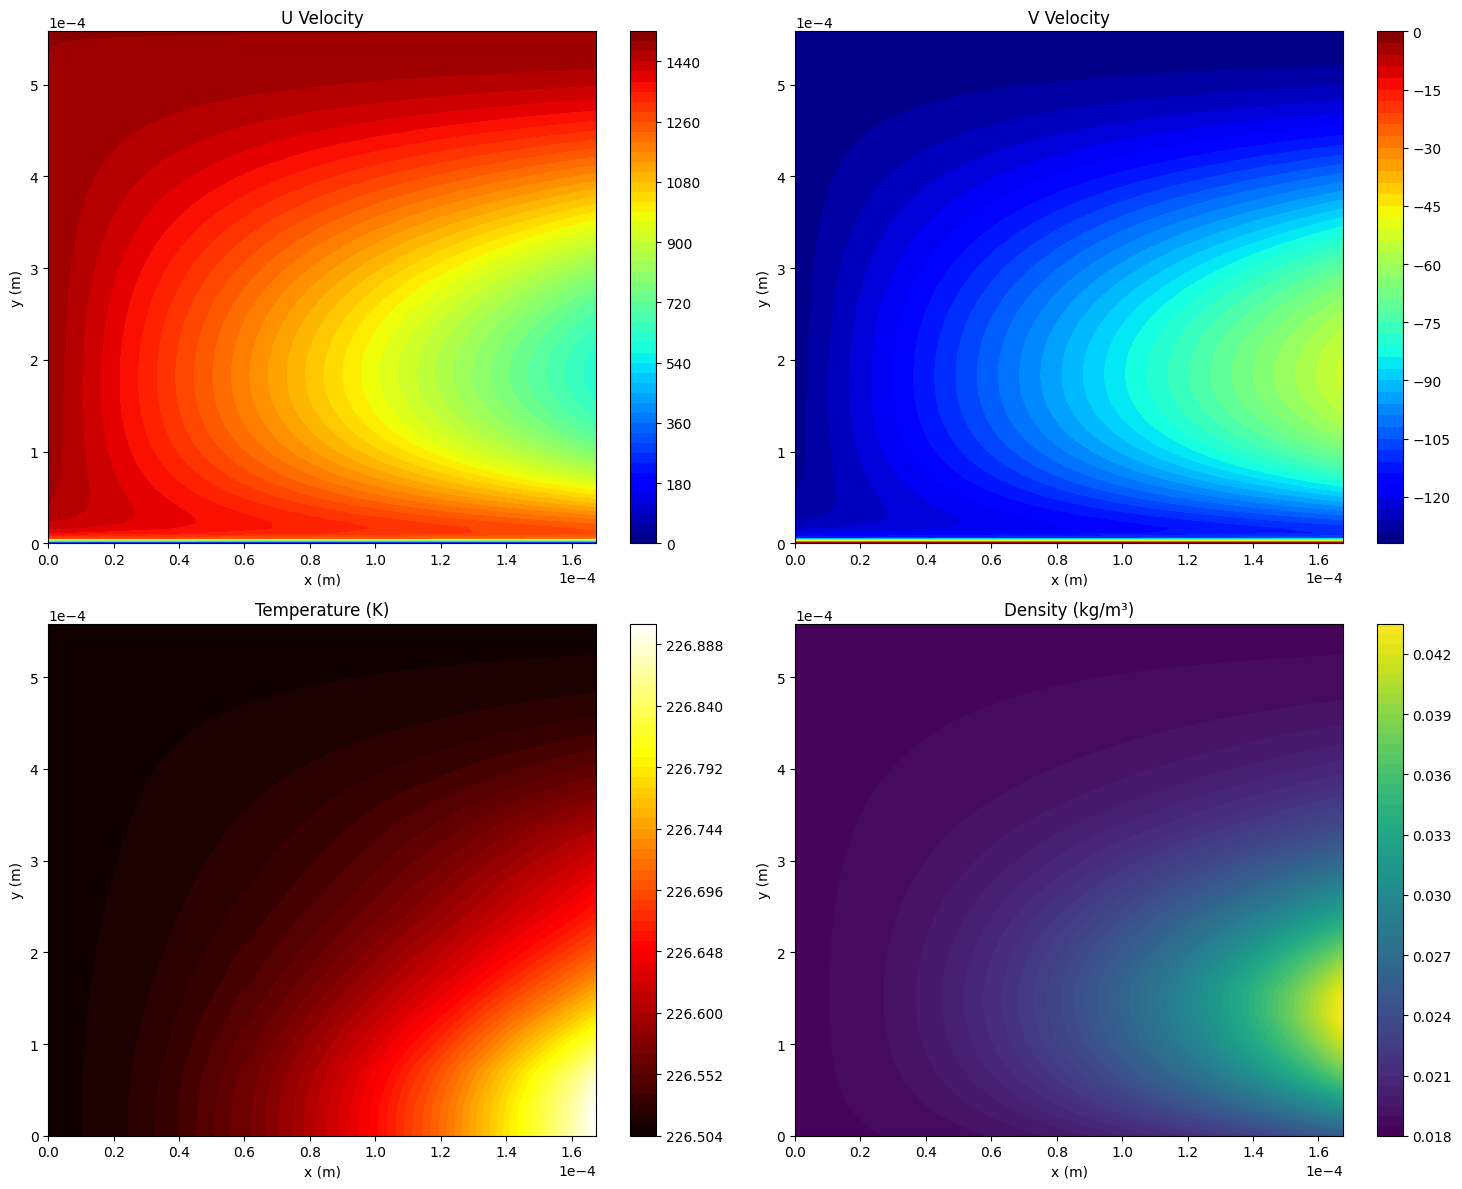

In [10]:
# u_pred = model.predict(X_train1)
# models.append(model)
u_predict = u_pred
x = np.linspace(0, 1, 100).reshape(-1, 1)
y = np.linspace(0, 1, 100).reshape(-1, 1)
X_vis = np.hstack((x,y))
visualize_results(X_vis, u_predict, params_dict)

# 生成每一个时间步上的数据

In [19]:
# 生成时间步训练数据
# 输入时间步上的最大最小值，能够生成数据
# 内部点10000，边界点1000
def generate_timestep_data(params_dict,start,end):
    # 提取参数
    L = params_dict['L'].item()
    S = params_dict['S'].item()
    U_inf = params_dict['U_inf'].item()
    alpha = params_dict['alpha'].item()
    T_inf = params_dict['T_inf'].item()
    rho_inf = params_dict['rho_inf'].item()

    # 生成x, y网格
    x = np.linspace(0, L, 100).reshape(-1, 1)
    y = np.linspace(0, S, 100).reshape(-1, 1)
    t = np.linspace(start,end,10).reshape(-1,1)
    X, Y ,T= np.meshgrid(x, y, t)

    # 生成初始点的数据
    X_bc = np.hstack((X[:,:,0].flatten().reshape(-1,1),Y[:,:,0].flatten().reshape(-1,1),T[:,:,0].flatten().reshape(-1,1)))

    # 生成内部点的数据
    X_ic = np.hstack((X.flatten().reshape(-1,1),Y.flatten().reshape(-1,1),T.flatten().reshape(-1,1)))

    # 随机选点
    idx1 = np.random.choice(X_bc.shape[0],1000,replace = False)
    idx2 = np.random.choice(X_ic.shape[0],10000,replace = False)

    X_bc = X_bc[idx1,:]
    X_ic = X_ic[idx2,:]

    # 标准化
    X_bc_norm = X_bc.copy()
    X_bc_norm[:, 0:1] = X_bc_norm[:, 0:1] / L  # 归一化x
    X_bc_norm[:, 1:2] = X_bc_norm[:, 1:2] / S  # 归一化y
    X_ic_norm = X_ic.copy()
    X_ic_norm[:, 0:1] = X_ic_norm[:, 0:1] / L  # 归一化x
    X_ic_norm[:, 1:2] = X_ic_norm[:, 1:2] / S  # 归一化y

    return X_bc_norm ,X_ic_norm


# 时间步进PINN模型

In [16]:
premodel = models[-1]
x = np.linspace(0, 1, 10000).reshape(-1, 1)
y = np.linspace(0, 1, 10000).reshape(-1, 1)
t = np.linspace(0,0.5,10000).reshape(-1,1)

x = torch.tensor(x, requires_grad=True).float().to(device)
y = torch.tensor(y, requires_grad=True).float().to(device)
t = torch.tensor(t, requires_grad=True).float().to(device)

u_pre,_,_,_ = premodel.net_u(x,y,t)   # 10000*1
u_pre = u_pre.detach()
type(u_pre)


torch.Tensor

In [26]:
class Multi_hPINN_Next():
    def __init__(self, X_bc, X_ic, layers, premodel, t_min, t_max):
        # 保存前一个模型
        self.premodel = premodel
        # 停止前一个模型参数的训练
        for param in self.premodel.dnn.parameters():
            param.requires_grad = False

        # 时间区间设
        self.t_min = t_min
        self.t_max = t_max
        # 定义分段函数的断点 - 使用nn.Parameter确保它是可优化的叶节点
        breakpoint_value = self.t_min + (self.t_max - self.t_min) * 0.5
        self.breakpoint = torch.nn.Parameter(torch.tensor(breakpoint_value).float().to(device))
        print(f"断点初始化位置: {self.breakpoint.item():.3f}")
        self.breakpoint_log = []

        # 添加可训练的p参数，跟踪其变化
        self.p = torch.nn.Parameter(torch.tensor(2.0).float().to(device))
        self.p_log = []

        # data
        self.x_bc = torch.tensor(X_bc[:, 0:1], requires_grad=True).float().to(device)
        self.y_bc = torch.tensor(X_bc[:, 1:2], requires_grad=True).float().to(device)
        self.t_bc = torch.tensor(X_bc[:, 2:3], requires_grad=True).float().to(device)

        self.x_ic = torch.tensor(X_ic[:, 0:1], requires_grad=True).float().to(device)
        self.y_ic = torch.tensor(X_ic[:, 1:2], requires_grad=True).float().to(device)
        self.t_ic = torch.tensor(X_ic[:, 2:3], requires_grad=True).float().to(device)

        # parameters
        self.alpha = torch.tensor((5/180)*torch.pi).float().to(device)
        self.U_inf = torch.tensor(1508.55).float().to(device)
        self.T_inf = torch.tensor(226.51).float().to(device)
        self.rho_inf = torch.tensor(1.841e-2).float().to(device)
        self.P_inf = torch.tensor(1.197e3).float().to(device)
        self.C_inf = torch.tensor(301.71).float().to(device)
        self.S = torch.tensor(5.5811e-4).float().to(device)
        self.R = torch.tensor(287).float().to(device)
        self.mu0 = torch.tensor(1.789e-5).float().to(device)
        self.C = torch.tensor(110.4).float().to(device)
        self.T0 = torch.tensor(288.15).float().to(device)
        self.Tve = torch.tensor(3030).float().to(device)
        self.Pr = torch.tensor(0.72).float().to(device)
        self.L = torch.tensor(1.675e-4).float().to(device)
        self.loss = None
        self.layers = layers

        # dnn
        self.dnn = DNN(layers).to(device)
        
        # 对于Adam
        self.optimizer_adam = torch.optim.Adam([
            {'params': self.dnn.parameters()},
            # {'params': [self.p], 'lr': 0.001}  # 降低p参数的学习率
        ], lr=10)
        # 对于LBFGS
        all_params = list(self.dnn.parameters()) + [self.breakpoint] # + [self.p]
        self.optimizer_lbfgs = torch.optim.LBFGS(
            all_params,
            lr=0.1,
            max_iter=1000,
            max_eval=1000,
            history_size=50,
            tolerance_grad=1e-5,
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"
        )
        
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer_adam, step_size=1000, gamma=0.9)
        self.optimizer = None
        self.iter = 0

    def control_fun(self, x, y):
        """控制函数 4xy(1-y)^p，用于平滑地连接解析解和神经网络输出"""
        return 4 * x * y * (torch.ones_like(y) - y) ** self.p

    def time_control_fun(self, t):
        """时间控制函数，用于平滑地连接两个网络的输出"""
        # 确保t是需要梯度的张量
        if not t.requires_grad:
            t = t.detach().clone().requires_grad_(True)

        ab = self.breakpoint
        condition2 = t <= self.t_min
        condition3 = t <= ab

        # 使用平滑的三次多项式插值，确保梯度连续
        B = (t - self.t_min) / (ab - self.t_min)
        BB = B**2

        result = torch.where(condition2, torch.zeros_like(t),
                      torch.where(condition3, -2*B*BB + 3*BB, torch.ones_like(t)))
        return result

    def net_u(self, x, y, t):
        # 计算控制权重
        time_weight = self.time_control_fun(t)
        space_weight = self.control_fun(x, y)
        
        # 前一个模型的输出
        # 不能直接使用no_grad计算前一个模型的输出，否则会丢失梯度
        u_pre, _, _, _ = self.premodel.net_u(x, y, t)
        # 分离前一个模型的输出，防止梯度传播到前一个模型
        u_pre = u_pre.detach()
        print('前一个模型的u',torch.mean(u_pre),u_pre.shape)

        # 当前模型输出
        N1, _, _, _ = self.dnn(torch.cat([x, y, t], dim=1))

        x1 = torch.zeros_like(x, requires_grad=True)
        
        N1x1, N1x1_x, _, _ = self.dnn(torch.cat([x1, y, t], dim=1))
        N1x1_xx = torch.autograd.grad(
            N1x1_x,
            x1,
            grad_outputs=torch.ones_like(N1x1_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        # 神经网络部分
        u_nn = self.L*self.S**2*x*y*(torch.ones_like(y)-y)*(N1 -x*N1x1_x - 1/2*N1x1_xx)
        
        # 最终输出：时间维度上的组合
        u = (1 - space_weight)*(1 - time_weight) * u_pre + time_weight * space_weight * u_nn

        u_x = torch.autograd.grad(
            u, x,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_y = torch.autograd.grad(
            u, y,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_t = torch.autograd.grad(
            u, t,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        print('u_nn:',u_nn,'space_weight:',space_weight,'time_weight:',time_weight)
        print('u的输出',torch.mean(u), torch.mean(u_x), torch.mean(u_y), torch.mean(u_t))
        return u, u_x, u_y, u_t

    def net_v(self, x, y, t):
        # 计算控制权重
        time_weight = self.time_control_fun(t)
        space_weight = self.control_fun(x, y)

        # 前一个模型的输出
        v_pre, _, _, _ = self.premodel.net_v(x, y, t)
        v_pre = v_pre.detach()
        print('前一个模型的v',torch.mean(v_pre),v_pre.shape)

        # 当前模型输出
        _, N2, _, _ = self.dnn(torch.cat([x, y, t], dim=1))
        
        x1 = torch.zeros_like(x, requires_grad=True)
        N2x1, N2x1_x, _, _ = self.dnn(torch.cat([x1, y, t], dim=1))
        N2x1_xx = torch.autograd.grad(
            N2x1_x,
            x1,
            grad_outputs=torch.ones_like(N2x1_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        # 神经网络部分
        v_nn = self.L*self.S**2*x*y*(torch.ones_like(y)-y)*(N2 -x*N2x1_x - 1/2*N2x1_xx)

       
        # 最终输出
        v = (1 - space_weight) * (1 - time_weight) * v_pre + space_weight * time_weight * v_nn

        v_x = torch.autograd.grad(
            v, x,
            grad_outputs=torch.ones_like(v),
            retain_graph=True,
            create_graph=True
        )[0]
        v_y = torch.autograd.grad(
            v, y,
            grad_outputs=torch.ones_like(v),
            retain_graph=True,
            create_graph=True
        )[0]
        v_t = torch.autograd.grad(
            v, t,
            grad_outputs=torch.ones_like(v),
            retain_graph=True,
            create_graph=True
        )[0]

        print('v的输出',torch.mean(v), torch.mean(v_x), torch.mean(v_y), torch.mean(v_t))
        return v, v_x, v_y, v_t

    def net_T(self, x, y, t):
        # 计算控制权重
        time_weight = self.time_control_fun(t)
        space_weight = (x*(torch.ones_like(y)-y))**self.p

        # 前一个模型的输出
        T_pre, _, _, _ = self.premodel.net_T(x, y, t)
        T_pre = T_pre.detach()
        print('前一个模型的T',torch.mean(T_pre),T_pre.shape)
        
        # 当前模型输出
        _, _, N3, _ = self.dnn(torch.cat([(1-x)**3, y**2, t], dim=1))
        

        # 神经网络部分
        T_nn = self.S*self.L*N3
        
        # 最终输出
        T = (1 - space_weight) * (1 - time_weight) * T_pre + space_weight*time_weight * T_nn

        T_x = torch.autograd.grad(
            T, x,
            grad_outputs=torch.ones_like(T),
            retain_graph=True,
            create_graph=True
        )[0]
        T_y = torch.autograd.grad(
            T, y,
            grad_outputs=torch.ones_like(T),
            retain_graph=True,
            create_graph=True
        )[0]
        T_t = torch.autograd.grad(
            T, t,
            grad_outputs=torch.ones_like(T),
            retain_graph=True,
            create_graph=True
        )[0]

        print('T的输出',torch.mean(T), torch.mean(T_x), torch.mean(T_y), torch.mean(T_t))
        return T, T_x, T_y, T_t
        
    def net_rho(self, x, y, t):
        # 计算控制权重
        time_weight = self.time_control_fun(t)
        space_weight = (x*(torch.ones_like(y)-y))**self.p

        # 前一个模型的输出
        rho_pre, _, _, _ = self.premodel.net_rho(x, y, t)
        rho_pre = rho_pre.detach()
        print('前一个模型的rho',torch.mean(rho_pre),rho_pre.shape)

        # 当前模型输出
        _, _, _, N4 = self.dnn(torch.cat([x, y, t], dim=1))
        
        x1 = torch.zeros_like(x, requires_grad=True)
        N4x1, N4x1_x, _, _ = self.dnn(torch.cat([x1, y, t], dim=1))
        N4x1_xx = torch.autograd.grad(
            N4x1_x,
            x1,
            grad_outputs=torch.ones_like(N4x1_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        # 神经网络部分
        rho_nn = self.L*self.S*x*(torch.ones_like(y)-y)*(N4 -x*N4x1_x - 1/2*N4x1_xx)

        # 最终输出
        rho = (1 - space_weight) *(1 - time_weight) * rho_pre + space_weight * time_weight * rho_nn

        rho_x = torch.autograd.grad(
            rho, x,
            grad_outputs=torch.ones_like(rho),
            retain_graph=True,
            create_graph=True
        )[0]
        rho_y = torch.autograd.grad(
            rho, y,
            grad_outputs=torch.ones_like(rho),
            retain_graph=True,
            create_graph=True
        )[0]
        rho_t = torch.autograd.grad(
            rho, t,
            grad_outputs=torch.ones_like(rho),
            retain_graph=True,
            create_graph=True
        )[0]

        print('rho的输出',torch.mean(rho), torch.mean(rho_x), torch.mean(rho_y), torch.mean(rho_t))
        return rho, rho_x, rho_y, rho_t
    
    # 计算cp_T
    def calculate_cp_T(self, T):
        # 保证温度有一个最小值，防止除以接近零的数
        T_safe = torch.clamp(T, min=1.0)

        # 当T<600时，使用常数值
        cp_low = 1004.5

        # 当T>=600时的计算逻辑
        # 计算比值并限制其上限，防止exp爆炸
        ratio = torch.clamp(self.Tve / T_safe, max=20.0)

        # 更稳定的计算方式：避免大指数和分母为零的情况
        # 当ratio很大时，exp(ratio)>>1，所以exp(ratio)/(exp(ratio)-1)约等于1
        # 当ratio较小时，使用完整表达式
        # 使用log-sum-exp技巧提高数值稳定性
        exp_ratio = torch.exp(ratio)
        # 安全的分母计算
        denominator = exp_ratio - 1.0
        # 添加epsilon防止分母为零
        denominator = torch.clamp(denominator, min=1e-10)

        # 计算完整表达式
        term = (ratio**2) * (exp_ratio / denominator**2)

        # 组合最终结果
        cp_high = (7.0 / 2.0) * self.R + self.R * term

        # 使用torch.where选择
        return torch.where(T < 600, cp_low, cp_high)
        
    def function(self, x, y, t):
        # 速度u,v 温度T 密度rho, 压强p,
        u, u_x, u_y, u_t = self.net_u(x, y, t)
        v, v_x, v_y, v_t = self.net_v(x, y, t)
        T, T_x, T_y, T_t = self.net_T(x, y, t)
        rho, rho_x, rho_y, rho_t = self.net_rho(x, y, t)

        # 安全裁剪，防止极端值
        u_safe = torch.clamp(u, min=-2000.0, max=2000.0)
        v_safe = torch.clamp(v, min=-2000.0, max=2000.0)
        T_safe = torch.clamp(T, min=1.0, max=5000.0)
        rho_safe = torch.clamp(rho, min=1e-6, max=10.0)

        # 对导数也进行适当裁剪，避免极值
        max_deriv = 1e6
        u_x = torch.clamp(u_x, min=-max_deriv, max=max_deriv)
        u_y = torch.clamp(u_y, min=-max_deriv, max=max_deriv)
        u_t = torch.clamp(u_t, min=-max_deriv, max=max_deriv)
        v_x = torch.clamp(v_x, min=-max_deriv, max=max_deriv)
        v_y = torch.clamp(v_y, min=-max_deriv, max=max_deriv)
        v_t = torch.clamp(v_t, min=-max_deriv, max=max_deriv)
        T_x = torch.clamp(T_x, min=-max_deriv, max=max_deriv)
        T_y = torch.clamp(T_y, min=-max_deriv, max=max_deriv)
        T_t = torch.clamp(T_t, min=-max_deriv, max=max_deriv)
        rho_x = torch.clamp(rho_x, min=-max_deriv, max=max_deriv)
        rho_y = torch.clamp(rho_y, min=-max_deriv, max=max_deriv)
        rho_t = torch.clamp(rho_t, min=-max_deriv, max=max_deriv)

        p = rho*self.R*T
        p_x = torch.autograd.grad(
            p, x,
            grad_outputs=torch.ones_like(p),
            retain_graph=True,
            create_graph=True
        )[0]
        p_y = torch.autograd.grad(
            p, y,
            grad_outputs=torch.ones_like(p),
            retain_graph=True,
            create_graph=True
        )[0]
        mu_T = self.mu0*((self.T0+self.C)/(T+self.C))*(T/self.T0)**1.5

        cp_T = self.calculate_cp_T(T_safe)
        k_T = mu_T*cp_T/self.Pr
        
        # 分步计算粘性项，应用裁剪
        part1 = (4/3) * mu_T * u_x - (2/3) * mu_T * v_y
        part1_x = torch.autograd.grad(
            part1, x,
            grad_outputs=torch.ones_like(part1),
            retain_graph=True,
            create_graph=True
        )[0]
        part1_x = torch.clamp(part1_x, min=-max_deriv, max=max_deriv)

        part2 = mu_T * (u_y + v_x)
        part2_x = torch.autograd.grad(
            part2, x,
            grad_outputs=torch.ones_like(part2),
            retain_graph=True,
            create_graph=True
        )[0]
        part2_y = torch.autograd.grad(
            part2, y,
            grad_outputs=torch.ones_like(part2),
            retain_graph=True,
            create_graph=True
        )[0]
        part2_x = torch.clamp(part2_x, min=-max_deriv, max=max_deriv)
        part2_y = torch.clamp(part2_y, min=-max_deriv, max=max_deriv)

        part3 = (4/3) * mu_T * v_y - (2/3) * mu_T * u_x
        part3_y = torch.autograd.grad(
            part3, y,
            grad_outputs=torch.ones_like(part3),
            retain_graph=True,
            create_graph=True
        )[0]
        part3_y = torch.clamp(part3_y, min=-max_deriv, max=max_deriv)

        part4 = k_T * T_x
        part4_x = torch.autograd.grad(
            part4, x,
            grad_outputs=torch.ones_like(part4),
            retain_graph=True,
            create_graph=True
        )[0]
        part4_x = torch.clamp(part4_x, min=-max_deriv, max=max_deriv)

        part5 = k_T * T_y
        part5_y = torch.autograd.grad(
            part5, y,
            grad_outputs=torch.ones_like(part5),
            retain_graph=True,
            create_graph=True
        )[0]
        part5_y = torch.clamp(part5_y, min=-max_deriv, max=max_deriv)

        # 计算方程残差并应用裁剪
        f1 = rho_t + u_safe * rho_x + rho_safe * u_x + v_safe * rho_y + v_x * rho_safe
        f2 = rho_safe * (u_t + u_safe * u_x + v_safe * u_y) + p_x - part1_x - part2_y
        f3 = rho_safe * (v_t + u_safe * v_x + v_safe * v_y) + p_y - part3_y - part2_x

        # 能量方程各项分别计算并裁剪
        term1 = torch.clamp(rho_safe * cp_T * T_t, min=-max_deriv, max=max_deriv)
        term2 = torch.clamp(rho_safe * cp_T * u_safe * T_x, min=-max_deriv, max=max_deriv)
        term3 = torch.clamp(rho_safe * cp_T * v_safe * T_y, min=-max_deriv, max=max_deriv)
        term4 = torch.clamp(p * (u_x + v_y), min=-max_deriv, max=max_deriv)
        term5 = torch.clamp(-part4_x, min=-max_deriv, max=max_deriv)
        term6 = torch.clamp(-part5_y, min=-max_deriv, max=max_deriv)
        term7 = torch.clamp(-(4/3) * mu_T * (u_x**2), min=-max_deriv, max=max_deriv)
        term8 = torch.clamp(-mu_T * (u_y**2), min=-max_deriv, max=max_deriv)
        term9 = torch.clamp(-mu_T * (v_x**2), min=-max_deriv, max=max_deriv)
        term10 = torch.clamp(-(4/3) * mu_T * (v_y**2), min=-max_deriv, max=max_deriv)
        term11 = torch.clamp((4/3) * mu_T * u_x * v_y, min=-max_deriv, max=max_deriv)
        term12 = torch.clamp(-2 * mu_T * u_y * v_x, min=-max_deriv, max=max_deriv)

        # 计算能量方程的残差
        f4 = term1 + term2 + term3 + term4 + term5 + term6 + term7 + term8 + term9 + term10 + term11 + term12

        # 对所有残差进行最终裁剪
        max_residual = 1e8
        f1 = torch.clamp(f1, min=-max_residual, max=max_residual)
        f2 = torch.clamp(f2, min=-max_residual, max=max_residual)
        f3 = torch.clamp(f3, min=-max_residual, max=max_residual)
        f4 = torch.clamp(f4, min=-max_residual, max=max_residual)
        print(f'f1:{torch.mean(f1**2)},f2:{torch.mean(f2**2)},f3:{torch.mean(f3**2)},f4:{torch.mean(f4**2)}')

        return f1, f2, f3, f4

    # 在function方法之后添加一个加权损失计算方法
    def weighted_loss(self, x, y, t):
        f1, f2, f3, f4 = self.function(x, y, t)

        # 计算当前批次中每个损失的平均大小
        f1_mean = torch.mean(torch.abs(f1))
        f2_mean = torch.mean(torch.abs(f2))
        f3_mean = torch.mean(torch.abs(f3))
        f4_mean = torch.mean(torch.abs(f4))

        # 计算动态权重（使用均值的倒数）
        eps = 1e-10  # 防止除零
        w1 = 1.0 / (f1_mean + eps)
        w2 = 1.0 / (f2_mean + eps)
        w3 = 1.0 / (f3_mean + eps)
        w4 = 1.0 / (f4_mean + eps)

        # 归一化权重
        total = w1 + w2 + w3 + w4
        w1, w2, w3, w4 = w1/total, w2/total, w3/total, w4/total

        # 应用权重计算加权损失
        loss_f1 = w1 * torch.mean(f1**2)
        loss_f2 = w2 * torch.mean(f2**2)
        loss_f3 = w3 * torch.mean(f3**2)
        loss_f4 = w4 * torch.mean(f4**2)

        return loss_f1, loss_f2, loss_f3, loss_f4
        
    def closure(self):
        """闭包函数，用于优化过程"""
        self.optimizer.zero_grad()

        # 计算方程残差
        loss_f1, loss_f2, loss_f3, loss_f4 = self.weighted_loss(self.x_ic, self.y_ic, self.t_ic)

        # 总损失为方程残差
        loss = loss_f1 + loss_f2 + loss_f3 + loss_f4
        self.loss = loss

        # 执行反向传播
        loss.backward()

        self.iter += 1
        self.breakpoint_log.append(self.breakpoint.item())
        self.p_log.append(self.p.item())

        if self.iter % 1 == 0:
            time_weight0 = 1 - self.time_control_fun(self.t_ic[0]).item() if len(self.t_ic) > 0 else 0
            print(
                f'Iter {self.iter}, p:{self.p.item():.2f}, b:{self.breakpoint.item():.2f}, w0:{time_weight0:.2f}, Loss: {loss.item():.5e}, Loss_f1: {loss_f1.item():.5e}, Loss_f2: {loss_f2.item():.5e}, Loss_f3: {loss_f3.item():.5e}, Loss_f4: {loss_f4.item():.5e}'
            )

        return loss

    def train(self, n_iter, optimizer_type='adam'):
        '''训练模型 其中可以更改优化器的类型，以及训练迭代的设置'''
        # 其中参数n_iter指的是迭代次数 optimizer_type指的是优化器的类型
        self.dnn.train()
        if optimizer_type == 'adam':
            self.optimizer = self.optimizer_adam
            # Adam优化
            print('\n\t====开始Adam优化====')
            
        else:
            self.optimizer = self.optimizer_lbfgs
            print('\n\t====开始LBFGS优化====')

        for _ in range(n_iter):
            # print(self.loss_function)
            self.optimizer.step(self.closure)
            if (self.loss < 1e-6):
                break
        
        # 梯度裁剪
        # torch.nn.utils.clip_grad_norm_(self.dnn.parameters(), max_norm=1.0)

        # 绘制参数变化曲线
        if len(self.breakpoint_log) > 0:
            plt.figure(figsize=(15, 5))

            plt.subplot(1, 2, 1)
            plt.plot(range(len(self.breakpoint_log)), self.breakpoint_log)
            plt.title('断点位置变化')
            plt.xlabel('迭代次数')
            plt.ylabel('断点位置')
            plt.grid(True)

            plt.subplot(1, 2, 2)
            plt.plot(range(len(self.p_log)), self.p_log)
            plt.title('p参数变化')
            plt.xlabel('迭代次数')
            plt.ylabel('p值')
            plt.grid(True)

            plt.tight_layout()
            plt.show()

    def predict(self,X):
        x = torch.tensor(X[:,0:1], requires_grad=True).float().to(device)
        y = torch.tensor(X[:,1:2], requires_grad=True).float().to(device)
        t = torch.tensor(X[:,2:3], requires_grad=True).float().to(device)
        self.dnn.eval()

        # 预测速度 u
        u, _, _, _ = self.net_u(x, y, t)

        # 预测速度 v
        v, _, _, _ = self.net_v(x, y, t)

        # 预测温度 T
        T, _, _, _ = self.net_T(x, y, t)

        # 预测密度 rho
        rho, _, _, _ = self.net_rho(x, y, t)

        # 分离梯度并转换为NumPy数组
        u = u.detach().cpu().numpy()
        v = v.detach().cpu().numpy()
        T = T.detach().cpu().numpy()
        rho = rho.detach().cpu().numpy()

        return u, v, T, rho

# 训练后续步骤

In [27]:
t_block = np.linspace(t_min, t_max, num_block + 1)

print(f'训练区间: [{t_block[0]:.2f}, {t_block[0+1]:.2f}]')
# # 后续区间
X_bc,X_ic = generate_timestep_data(params_dict,t_block[0],t_block[0+1])
model = Multi_hPINN_Next(X_bc,X_ic, layers, models[-1],t_block[0], t_block[0+1])
# 训练模型
start_time = time.time()
model.train(100, 'adam')
# model.train(100, 'lbfgs')

训练区间: [0.00, 0.50]
断点初始化位置: 0.250

	====开始Adam优化====
前一个模型的u tensor(1229.3037, device='cuda:0') torch.Size([10000, 1])
u_nn: tensor([[-1.1717e-12],
        [-4.5210e-12],
        [-2.6116e-12],
        ...,
        [-5.2433e-12],
        [-2.3772e-12],
        [-9.0431e-12]], device='cuda:0', grad_fn=<MulBackward0>) space_weight: tensor([[0.0522],
        [0.0058],
        [0.2105],
        ...,
        [0.3800],
        [0.1895],
        [0.5264]], device='cuda:0', grad_fn=<MulBackward0>) time_weight: tensor([[0.9657],
        [0.0000],
        [0.9657],
        ...,
        [0.7407],
        [0.9657],
        [0.4170]], device='cuda:0', grad_fn=<WhereBackward0>)
u的输出 tensor(289.0184, device='cuda:0', grad_fn=<MeanBackward0>) tensor(-105.7417, device='cuda:0', grad_fn=<MeanBackward0>) tensor(9.3220, device='cuda:0', grad_fn=<MeanBackward0>) tensor(-1877.3948, device='cuda:0', grad_fn=<MeanBackward0>)
前一个模型的v tensor(-107.5501, device='cuda:0') torch.Size([10000, 1])
v的输出 tensor(-25.285

KeyboardInterrupt: 

# 训练每一步

In [ ]:
def train_block(layers,params_dict, t_min, t_max, num_block, nIter=1000):
    """分区间训练模型"""
    models = []
    errors = []
    train_times = []

    t_block = np.linspace(t_min, t_max, num_block + 1)

    for i in range(num_block):
        # print(f'训练区间: [{t_block[i]:.2f}, {t_block[i+1]:.2f}]')

        if i == 0:
            # 第一个区间
            print(f'训练区间: 初始时刻！')
            X_train1,u_train1 = generate_initial_data(params_dict)
            model = Multi_hPINN(X_train1, layers)
            # 训练模型
            start_time = time.time()
            model.train(nIter, 'adam')
            # model.train(100, 'lbfgs')
            u_pred = model.predict(X_train1)
        else:
            print(f'训练区间: [{t_block[i]:.2f}, {t_block[i+1]:.2f}]')
            # 后续区间
            X_bc,X_ic = generate_timestep_data(params_dict,t_block[i],t_block[i+1])
            model = Multi_hPINN_Next(X_bc,X_ic, layers, models[-1],t_block[i], t_block[i+1])

            # 训练模型
            start_time = time.time()
            model.train(nIter, 'adam')
            model.train(100, 'lbfgs')

            # # 绘制控制函数
            # t_plot = torch.linspace(t_min, t_max, 1000).to(device).requires_grad_(True)
            # # 不需要梯度的评估
            # with torch.no_grad():
            #     weight_values = model.control_fun(t_plot.reshape(-1, 1))

            # plt.figure(figsize=(8, 4))
            # plt.plot(t_plot.cpu().numpy(), weight_values.cpu().numpy())
            # plt.title('控制函数 w(t)')
            # plt.xlabel('t')
            # plt.ylabel('w(t)')
            # plt.grid(True)
            # plt.show()

            # # 显示断点位置变化
            # if len(model.breakpoint_log) > 0:
            #     plt.figure(figsize=(8, 4))
            #     plt.plot(range(len(model.breakpoint_log)), model.breakpoint_log)
            #     plt.title('断点位置变化')
            #     plt.xlabel('迭代次数')
            #     plt.ylabel('断点位置')
            #     plt.grid(True)
            #     plt.show()
            break
    #     train_time = (time.time() - start_time) / 60
    #     train_times.append(train_time)
    #     print(f'区间[{t_block[i]:.2f}, {t_block[i+1]:.2f}]的训练时间: {train_time:.2f}分钟')
    #     print(f'最终损失: {model.loss.item():.5e}, 总迭代次数: {model.iter}')

        models.append(model)

    # total_time = sum(train_times)
    # print(f'\n区间个数: {num_block}, 总训练时长: {total_time:.2f}分钟')

    return models, train_times,u_pred

In [ ]:
# def train_block(layers,params_dict, t_min, t_max, num_block, nIter=1000):
#     """分区间训练模型"""
#     models = []
#     errors = []
#     train_times = []

#     t_block = np.linspace(t_min, t_max, num_block + 1)

#     for i in range(num_block):
#         print(f'训练区间: [{t_block[i]:.2f}, {t_block[i+1]:.2f}]')

#         if i == 0:
#             # 第一个区间
#             X_train1,u_train1 = generate_initial_data(params_dict)
#             model = Multi_hPINN(X_train1, layers)
#             # 训练模型
#             start_time = time.time()
#             model.train(nIter, 'adam')
#             model.train(100, 'lbfgs')

#         else:
#             # 后续区间
#             X_bc,X_ic = generate_timestep_data(params_dict,t_block[i],t_block[i+1])
#             model = Multi_hPINN_Next(X_bc,X_ic, layers, models[-1],t_block[i], t_block[i+1])

#             # 训练模型
#             start_time = time.time()
#             model.train(nIter, 'adam')
#             model.train(100, 'lbfgs')

#             # 绘制控制函数
#             t_plot = torch.linspace(t_min, t_max, 1000).to(device).requires_grad_(True)
#             # 不需要梯度的评估
#             with torch.no_grad():
#                 weight_values = model.control_fun(t_plot.reshape(-1, 1))

#             plt.figure(figsize=(8, 4))
#             plt.plot(t_plot.cpu().numpy(), weight_values.cpu().numpy())
#             plt.title('控制函数 w(t)')
#             plt.xlabel('t')
#             plt.ylabel('w(t)')
#             plt.grid(True)
#             plt.show()

#             # 显示断点位置变化
#             if len(model.breakpoint_log) > 0:
#                 plt.figure(figsize=(8, 4))
#                 plt.plot(range(len(model.breakpoint_log)), model.breakpoint_log)
#                 plt.title('断点位置变化')
#                 plt.xlabel('迭代次数')
#                 plt.ylabel('断点位置')
#                 plt.grid(True)
#                 plt.show()

#         train_time = (time.time() - start_time) / 60
#         train_times.append(train_time)
#         print(f'区间[{t_block[i]:.2f}, {t_block[i+1]:.2f}]的训练时间: {train_time:.2f}分钟')
#         print(f'最终损失: {model.loss.item():.5e}, 总迭代次数: {model.iter}')

#         models.append(model)

#     total_time = sum(train_times)
#     print(f'\n区间个数: {num_block}, 总训练时长: {total_time:.2f}分钟')

#     return models, train_times

# 预测整个区间

In [ ]:
def predict_whole(models, X_pred, t_min, t_max, num_block):
    """整体区间预测"""
    t_block = np.linspace(t_min, t_max, num_block + 1)
    t_all = X_pred[:, 2:3]  # 提取时间维度

    u_pred_all = np.zeros_like(t_all)
    u_xx_all = np.zeros_like(t_all)
    v_pred_all = np.zeros_like(t_all)
    v_yy_all = np.zeros_like(t_all)

    # 对每个区间进行预测
    for i in range(num_block):
        idx = (t_all >= t_block[i]) & (t_all <= t_block[i+1])
        X_slice = X_pred[idx]

        if len(X_slice) > 0:
            u_pred, u_xx, v_pred, v_yy = models[i].predict(X_slice)

            # 确保输出和索引兼容
            u_pred_all[idx] = u_pred.flatten().reshape(-1, 1)
            u_xx_all[idx] = u_xx.flatten().reshape(-1, 1)
            v_pred_all[idx] = v_pred.flatten().reshape(-1, 1)
            v_yy_all[idx] = v_yy.flatten().reshape(-1, 1)

    return u_pred_all, u_xx_all, v_pred_all, v_yy_all

# 主程序代码

In [ ]:
# 主运行代码
if __name__ == "__main__":
    # 设置随机种子
    setup_seed(42)

    # 训练参数
    t_min, t_max = 0.0, 1.0  # 训练区间
    num_block = 2            # 区间数
    nIter = 10             # 每个区间的迭代次数

    # 模型参数
    params_dict = init_physics_params()

    # 定义网络层数
    layers = [3, 100, 90, 80, 60, 50, 40, 20, 4]

    # 调整时间点以适应分段训练
    t_steps = np.linspace(t_min, t_max, num_block + 1)

    # 创建包含不同时间点的预测数据
    # X_pred_list = []
    # for t in np.linspace(t_min, t_max, 5):  # 创建5个时间点的数据
    #     X_t = X_train1.copy()
    #     X_t[:, 2] = t
    #     X_pred_list.append(X_t)
    # X_pred = np.vstack(X_pred_list)

    # 训练模型
    models, train_times,u_pred = train_block(layers,params_dict, t_min, t_max, num_block, nIter=1000)
    # 全局预测
    # u_pred, u_xx, v_pred, v_yy = predict_whole(models, X_pred, t_min, t_max, num_block)

    # 可视化结果
    # visualize_results(X_pred, u_pred, u_xx, v_pred, v_yy, t_steps, num_block)

    # print("\n分段训练完成!")
    # print(f"总区间数: {num_block}")
    # print(f"训练区间: [{t_min}, {t_max}]")
    # print(f"总训练时间: {sum(train_times):.2f}分钟")

# 可视化结果

# 绘图

In [ ]:
# 绘图
u_predict = u_pred
u_p = u_predict[0].reshape(-1,100)
u_x0pred = u_p[:,0]
u_y0pred = u_p[0,:]
